In [1]:
import warnings
import numpy as np # linear algebra
from PIL import Image
# The below two are visualization libraires
import matplotlib.pyplot as plt
import seaborn as sns 
from sewar import full_ref
from skimage import measure
# for simple image processing tasks
from skimage import io
import math
# for clustering image pixels
from sklearn.cluster import KMeans 

# ignore warning messages
warnings.filterwarnings('ignore')


## Kmeans, SVD implementation


In [17]:
class k_means:
    def __init__(self,orig_array):
       
        self.orgImg = np.array(orig_array,dtype=float)/255
        self.w, self.h, self.d  = self.orgImg.shape

    def display_images(self,orgImg,compImg):
        plt.figure(figsize=(10,5))
        plt.subplot(1, 2, 1)
        plt.axis('off')
        plt.title('Original image')
        plt.imshow(orgImg)
        plt.subplot(1, 2, 2)
        plt.title('Compressed image')
        plt.imshow(compImg)
        

    def cal_kmeans(self,k):

        # image_array size - w*h , d
        image_array = self.orgImg.reshape(-1,self.d)
        
        # n_jobs=-1 --> means using all processors. 
        # verbose=2 --> provides details as to what the computer is doing and what drivers and software it is loading during startup.
        # n_init:int, default=10 --> Number of time the k-means algorithm will be run with different centroid seeds. The final results will be the best output of n_init consecutive runs in terms of inertia.
        # tol:float, default=1e-4 --> Relative tolerance with regards to Frobenius norm of the difference in the cluster centers of two consecutive iterations to declare convergence.
        # max_iter:int, default=300 --> Maximum number of iterations of the k-means algorithm for a single run.
        kmeans = KMeans(n_clusters = k,verbose=0,n_jobs=-1,n_init=5).fit(image_array)
        labels = kmeans.labels_
        centroids = kmeans.cluster_centers_
        
        return centroids, labels

    def compimage(self,centroids, labels):
        # centroids variable are calculated from the flattened image
        # centroids: w*h, d 
        # so each row depicts the values per depth
        compImg = np.zeros((self.w, self.h, self.d))
        label_idx = 0
        for i in range(self.w):
            for j in range(self.h):
                # filling values in new image with centroid values
                compImg[i][j] = centroids[labels[label_idx]]
                label_idx += 1
        return compImg
    
    def cal_imageSize(orig_array, comp_array, k):
        
        originalSize = self.w * self.h * 3
        compressedSize = self.w * self.h * math.log2(k)/8
        
        return originalSize, compressedSize

class SVD:
    def __init__(self,orig_array):
       
        self.aRed = orig_array[:, :, 0]
        self.aGreen = orig_array[:, :, 1]
        self.aBlue = orig_array[:, :, 2]
    
    # compress the matrix of a single channel
    def SVD_per_Channel(self,channelDataMatrix,k):
        
        u, s, vt = np.linalg.svd(channelDataMatrix)
        aChannelCompressed = np.zeros((channelDataMatrix.shape[0], channelDataMatrix.shape[1]))

        leftSide = np.matmul(u[:, 0:k], np.diag(s)[0:k, 0:k])
        ChannelCompressedInner = np.matmul(leftSide, vt[0:k, :])
        ChannelCompressed = ChannelCompressedInner.astype('uint8')
        
        return ChannelCompressed
    
    def cal_SVD(self,k):
        #k=singular value limit
        
        aRedCompressed = self.SVD_per_Channel(self.aRed, k)
        aGreenCompressed = self.SVD_per_Channel(self.aGreen, k)
        aBlueCompressed = self.SVD_per_Channel(self.aBlue, k)

        imr = Image.fromarray(aRedCompressed, mode=None)
        img = Image.fromarray(aGreenCompressed, mode=None)
        imb = Image.fromarray(aBlueCompressed, mode=None)

        compImage = Image.merge("RGB", (imr, img, imb))
        compImage = np.array(compImage)
        
        return compImage
    
    def display_images(self,orgImg,compImg):
        plt.figure(figsize=(10,5))
        plt.subplot(1, 2, 1)
        plt.axis('off')
        plt.title('Original image')
        plt.imshow(orgImg)
        plt.subplot(1, 2, 2)
        plt.title('Compressed image')
        plt.imshow(compImg)
    
  
        
class metrics:
    def __init__(self,ref_img, img,k,choose):
        self.ref_img=ref_img
        self.img=img
        self.choose=choose
        self.org_Width = self.ref_img.shape[0]
        self.org_Height = self.ref_img.shape[1]
        self.k=k
        
    def SVD_imageSize(self):
        
        originalSize = self.org_Height *  self.org_Width * 3
        compressedSize = self.k * (1 + self.org_Height + self.org_Width) * 3
        return originalSize, compressedSize
   
    def Kmeans_imageSize(self):
        originalSize = self.org_Width*self.org_Height*24
        #Compressed image needs 24K+Nlog2K bits 
        compressedSize =  self.org_Width*self.org_Height*math.log2(self.k)
        return originalSize, compressedSize  
    
    def print_metrics(self):

        # compression ratio(CR)
        if self.choose == 0:
            originalSize, compressedSize = self.SVD_imageSize()
            svd_ratio = compressedSize * 1.0 / originalSize
            print("compression ratio(CR) of SVD " +str(k)+" colors = "+str(int(svd_ratio*100))+"%")
        elif self.choose == 1:
            originalSize, compressedSize = self.Kmeans_imageSize()
            kmeans_ratio = compressedSize * 1.0 / originalSize
            print("compression ratio(CR) of Kmeans " +str(k)+" colors = "+str(int(kmeans_ratio*100))+"%")

        #Root Mean Squared Error(RMSE)
        """calculates root mean squared error (rmse).
            :param GT: first (original) input image.
            :param P: second (deformed) input image.
            :returns:  float -- rmse value.
            """
        rmse_img = full_ref.rmse(self.ref_img, self.img)
        print("RMSE: root mean squared error = ", rmse_img)

        #peak signal to noise ratio(PSNR)
        psnr_skimg = measure.compare_psnr(self.ref_img, self.img, data_range=None)
        print("PSNR: based on scikit-image = ", psnr_skimg)

        #ERGAS Global relative error
        """calculates global relative error 
            GT: first (original) input image.
            P: second (deformed) input image.
            r: ratio of high resolution to low resolution (default=4).
            ws: sliding window size (default = 8).
                :returns:  float -- ergas value.
                """
        ergas_img = full_ref.ergas(self.ref_img, self.img, r=4, ws=8)
        print("EGRAS: global relative error = ", ergas_img)

        # calculates spectral angle mapper (sam).
        """calculates spectral angle mapper (sam).
            :param GT: first (original) input image.
            :param P: second (deformed) input image.
            :returns:  float -- sam value.
            """
        ref_sam_img = full_ref.sam(self.ref_img, self.img)
        print("REF_SAM: spectral angle mapper = ", ref_sam_img)

        # Universal image quality index
        """calculates universal image quality index (uqi).
            :param GT: first (original) input image.
            :param P: second (deformed) input image.
            :param ws: sliding window size (default = 8).
            :returns:  float -- uqi value.
            """
        UQI_img = full_ref.uqi(self.ref_img, self.img, ws=8)
        print("UQI: universal image quality index = ", UQI_img)

        #Pixel Based Visual Information Fidelity (vif-p)
        """calculates Pixel Based Visual Information Fidelity (vif-p).
            :param GT: first (original) input image.
            :param P: second (deformed) input image.
            :param sigma_nsq: variance of the visual noise (default = 2)
            :returns:  float -- vif-p value.
            """
        VIFP_img = full_ref.vifp(self.ref_img, self.img, sigma_nsq=2)
        print("VIFP: Pixel Based Visual Information Fidelity = ", VIFP_img)



## K-means drive code

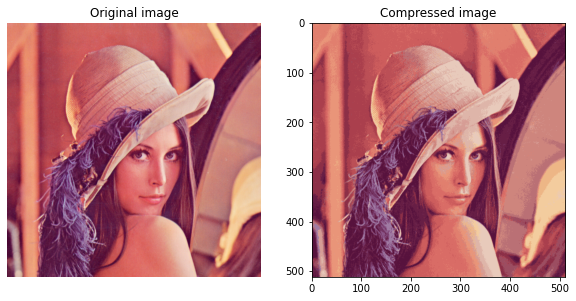

In [18]:
k=20
path = 'lena.png'
orig_image = Image.open(path)
orig_array = np.array(orig_image)

#kmeans drive code
kmeansObj = k_means(orig_array)
centroids,labels = kmeansObj.cal_kmeans(k)
kmeans_compImage = kmeansObj.compimage(centroids, labels)
kmeansObj.display_images(kmeansObj.orgImg,kmeans_compImage)




## SVD drive code

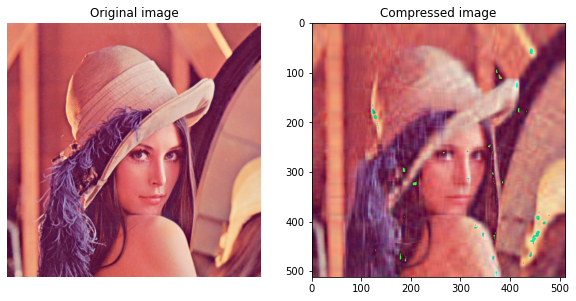

In [19]:
SVDObj = SVD(orig_array)
SVD_compImage = SVDObj.cal_SVD(k)
SVDObj.display_images(orig_array,SVD_compImage)

## Metrics drive code

In [20]:
SVD_metrics = metrics(orig_array,SVD_compImage,k,0)
Kmeans_metrics = metrics(orig_array,kmeans_compImage*255,k,1)

print("################# SVD metrics ##############")
SVD_metrics.print_metrics()
print("\n################# k-means metrics ##############")
Kmeans_metrics.print_metrics()



################# SVD metrics ##############
compression ratio(CR) of SVD 20 colors = 7%
RMSE: root mean squared error =  15.936109215383846
PSNR: based on scikit-image =  24.0831576596318
EGRAS: global relative error =  5127.089749511165
REF_SAM: spectral angle mapper =  0.12060431620369638
UQI: universal image quality index =  0.981156452330795
VIFP: Pixel Based Visual Information Fidelity =  0.210047296052936

################# k-means metrics ##############
compression ratio(CR) of Kmeans 20 colors = 18%
RMSE: root mean squared error =  7.573770851422163
PSNR: based on scikit-image =  30.544560385347257
EGRAS: global relative error =  2885.1539315797027
REF_SAM: spectral angle mapper =  0.05853028156437016
UQI: universal image quality index =  0.9959024118506813
VIFP: Pixel Based Visual Information Fidelity =  0.4131529551249367
